<a href="https://colab.research.google.com/github/punchnami/RBC-AI-Powered-Research-Query-Chatbot/blob/main/PredictiveModel_arimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Needed Packages

In [2]:
! pip -q install investpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 26.0 MB/s eta 0:00:00


# Import Needed Libraries

In [62]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Data Cleaning & Merging

In [4]:
## Search Sheet ##

# Define the path to the Excel file
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(search_file_path)

# Drop columns where all values are null
df_cleaned = df.dropna(axis=1, how='all')

# Drop the 'Footnote ID' column
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])

# Keep only rows where 'Rate Type' is 'BGCR'
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']

df_BGCR = df_cleaned.copy()

df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})


## Daily Treasury Rates Sheet ##

# Define the path to the directory containing the CSV files
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'

# List of files to concatenate
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]

# List to store individual DataFrames
df_list = []

# Loop through the files and read them into DataFrames
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(df_list, ignore_index=True)

# Drop columns where all values are null
merged_df = merged_df.dropna(axis=1, how='all')

# Drop the 'Footnote ID' column if it exists
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])

merged_daily_treasury_rates = merged_df.copy()


## Daily Treasury Rates LT Sheet ##

# Define the path to the directory containing the CSV files
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'

# List of files to concatenate
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]

# List to store individual DataFrames
df_list = []

# Loop through the files and read them into DataFrames
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(df_list, ignore_index=True)

# Drop columns where all values are null
merged_df = merged_df.dropna(axis=1, how='all')

# Drop the 'Footnote ID' column if it exists
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])

merged_daily_treasury_LT_rates = merged_df.copy()


## Merge DataFrames on 'Date' ##
df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')


## Feature Addition ##

# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']


## List of columns to keep ## - basis of this??? WENDY?

columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]

# Create a new DataFrame with only the relevant columns
df_relevant = df_merged[columns_to_keep]


## Merge DataFrames on 'Date' ##

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')

df_merged['Date'] = pd.to_datetime(df_merged['Date'])


## CPI Data ##

cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}

# Converting CPI data to DataFrame
cpi_df = pd.DataFrame(cpi_data)

# Melting the CPI DataFrame to long format
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
cpi_long_df['Day'] = 1

# Creating a date column in the CPI DataFrame
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
cpi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known CPI value of each month
cpi_long_df = cpi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
cpi_long_df.reset_index(inplace=True)

cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

# Merging the dataframes
df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')
df_merged2

## SPX ##

# Define the path to the directory containing the CSV files
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
# Load the csv file into a DataFrame
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])


## Merge DataFrames on 'Date' ##

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')


## NASDAQ ##

# Define the path to the directory containing the CSV files
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
# Load the csv file into a DataFrame
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])
df_merged3 = pd.merge(df_merged3, df, on='Date', how='inner')


## DJIA ##

# Define the path to the directory containing the CSV files
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
# Load the csv file into a DataFrame
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])
df_merged3 = pd.merge(df_merged3, df, on='Date', how='inner')


## FOR-EX ##

# Define the path to the directory containing the CSV files
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
# Load the csv file into a DataFrame
df = pd.read_csv(forex_path)
# Remove the first 5 rows
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
# Merge DataFrames on 'Date'
df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')
df_merged4


## FED Rate ##

# Define the path to the directory containing the CSV files
fed_rate_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal/federal fund rate.xlsx'
# Load the excel file into a DataFrame
df = pd.read_excel(fed_rate_path)
df = df[df['Rate Type'] == 'BGCR']
df = pd.DataFrame(df, columns=['Effective Date', 'Rate (%)'])
df = df.rename(columns={'Effective Date': 'Date'})
df = df.rename(columns={'Rate (%)': 'Fed_Fund_Rate'})
df['Date'] = pd.to_datetime(df['Date'])
# Merge DataFrames on 'Date'
df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')
df_merged5

<ipython-input-4-eac1f4f01710>:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,...,Yield Spread (20Y - 52W),CPI,SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",Fed_Fund_Rate
0,2024-06-21,BGCR,5.30,5.25,5.30,5.31,5.37,760,5.31,5.37,...,-0.62,314.069,5464.62,17689.36,39150.33,1.0694,1.2645,7.2609,159.4500,5.30
1,2024-06-20,BGCR,5.31,5.25,5.31,5.31,5.36,767,5.31,5.38,...,-0.62,314.069,5473.17,17721.59,39134.76,1.0708,1.2671,7.2604,158.7700,5.31
2,2024-06-18,BGCR,5.32,5.25,5.32,5.32,5.41,763,5.29,5.38,...,-0.62,314.069,5487.03,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100,5.32
3,2024-06-17,BGCR,5.32,5.26,5.31,5.32,5.42,772,5.34,5.39,...,-0.59,314.069,5473.23,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000,5.32
4,2024-06-14,BGCR,5.30,5.25,5.30,5.31,5.37,785,5.35,5.39,...,-0.60,314.069,5431.60,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800,5.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2018-04-06,BGCR,1.70,1.60,1.70,1.70,1.83,352,1.67,1.73,...,0.83,250.546,2604.47,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300,1.70
1552,2018-04-05,BGCR,1.70,1.60,1.70,1.70,1.85,349,1.66,1.72,...,0.88,250.546,2662.84,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800,1.70
1553,2018-04-04,BGCR,1.70,1.57,1.70,1.70,1.81,348,1.68,1.71,...,0.84,250.546,2644.69,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600,1.70
1554,2018-04-03,BGCR,1.81,1.50,1.80,1.82,1.97,344,1.70,1.75,...,0.81,250.546,2614.45,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500,1.81


# Final Dataframe OLD

In [5]:
df_final = df_merged5.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])
# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2


# Replace 'ND' with NaN and fill with a method or drop rows
df_final.replace('ND', np.nan, inplace=True)

# Define features and target
features = df_final.drop(columns=['Rate (%)'])  # Drop target column
target = df_final['Rate (%)']

# Check for NaN values in the original features dataframe before dropping
print("NaN values in original features dataframe before dropping:")
print(features.isna().sum())

# Drop rows with NaN values in the original features dataframe
features.dropna(inplace=True)
target = target[features.index]  # Ensure the target aligns with the dropped features

# Re-check for any remaining NaN values
print("NaN values in original features dataframe after dropping:")
print(features.isna().sum())

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Prepare the data for LSTM
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 30

# Create sequences
X, y = create_sequences(features_scaled, target.values, seq_length)

# Check for NaN values in the sequences again
print(f"NaN values in X after dropping NaNs: {np.isnan(X).sum()}")
print(f"NaN values in y after dropping NaNs: {np.isnan(y).sum()}")

# Proceed with splitting the data and training if NaN values are handled
if np.isnan(X).sum() == 0 and np.isnan(y).sum() == 0:
    # Split the data into training and testing sets
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print(f'Training set shape: {X_train.shape}, {y_train.shape}')
    print(f'Testing set shape: {X_test.shape}, {y_test.shape}')

NaN values in original features dataframe before dropping:
Volume ($Billions)                                                0
4 WEEKS COUPON EQUIVALENT                                         0
13 WEEKS COUPON EQUIVALENT                                        0
26 WEEKS COUPON EQUIVALENT                                        0
52 WEEKS COUPON EQUIVALENT                                        0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                 

# ARIMAX OLD

<Axes: xlabel='Date'>

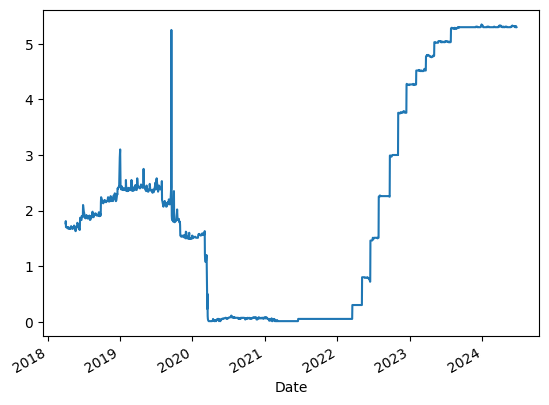

In [6]:
# Plot to check for seasonality

df_final2["Rate (%)"].plot()

Based on above we can conclude that SARIMAX is not required though it could be that due to the x-axis values that is not coming out.

In [16]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

model = SARIMAX(y_train, exog= X_train_reshaped, order= (1,1,1), seasonal_order= (0,0,0,0))

model_fit= model.fit(disp= False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1214
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1115.715
Date:                Sun, 14 Jul 2024   AIC                           -845.431
Time:                        14:08:06   BIC                           2689.460
Sample:                             0   HQIC                           485.427
                               - 1214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3917      0.416     -0.941      0.347      -1.208       0.424
x2         -2.037e+11      0.253  -8.05e+11      0.000   -2.04e+11   -2.04e+11
x3         -1.882e+12      0.421  -4.47e+12      0.0

In [17]:
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 1200x600 with 0 Axes>

# Final Dataframe New with Fed Fund Rate column

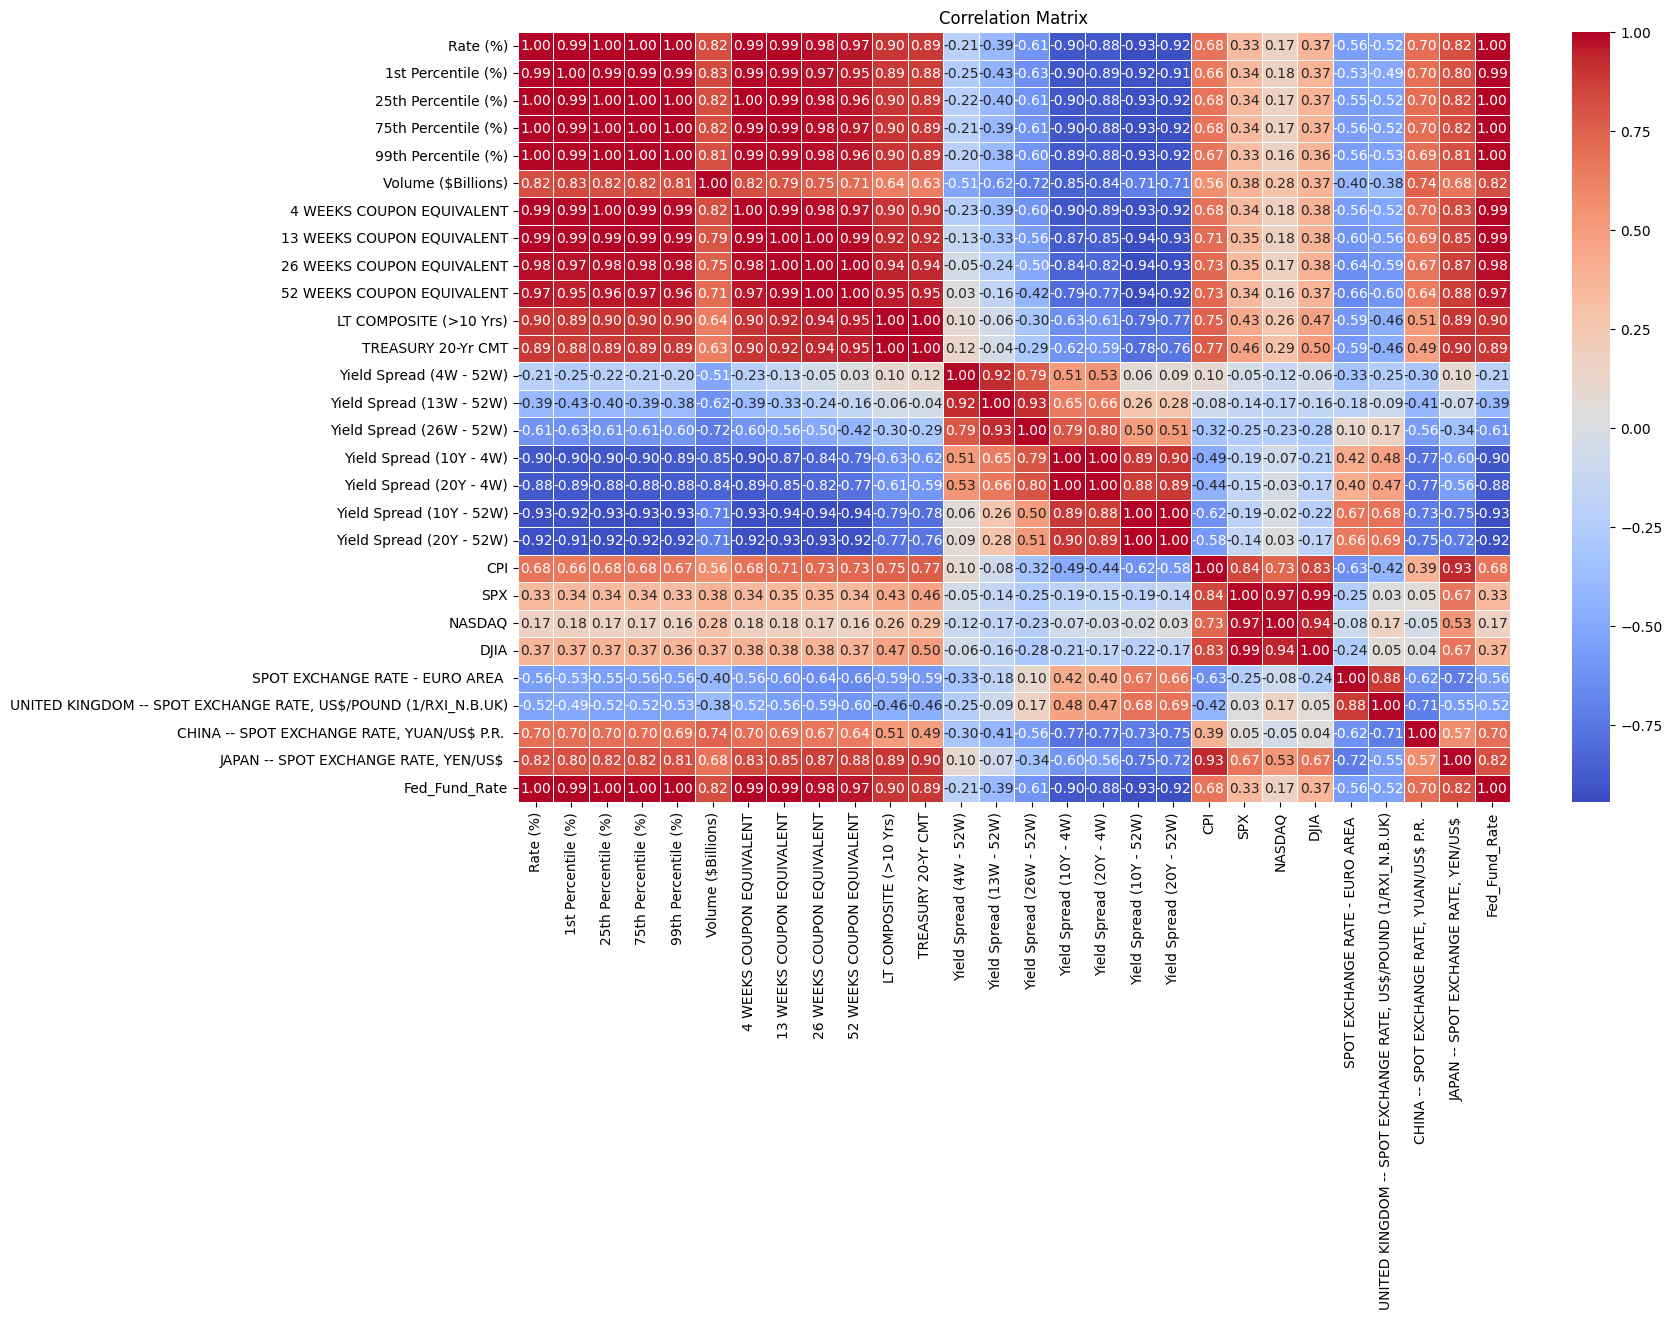

In [155]:
df_final = df_merged5.copy()

df_numeric = df_final.drop(columns=['Date', 'Rate Type'])
df_numeric.replace('ND', np.nan, inplace=True)

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Visualize the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [156]:
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_final2.isna().sum())

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_final2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
4 WEEKS COUPON EQUIVALENT                                         0
13 WEEKS COUPON EQUIVALENT                                        0
26 WEEKS COUPON EQUIVALENT                                        0
52 WEEKS COUPON EQUIVALENT                                        0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                 

In [157]:
df_final2

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Yield Spread (20Y - 52W),CPI,SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",Fed_Fund_Rate
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-02,1.77,361,1.67,1.77,1.92,2.08,2.90,2.85,0.41,0.31,...,0.77,250.546,2581.88,6870.12,23644.19,1.2288,1.4032,6.2785,105.9900,1.77
2018-04-03,1.81,344,1.70,1.75,1.92,2.09,2.96,2.90,0.39,0.34,...,0.81,250.546,2614.45,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500,1.81
2018-04-04,1.70,348,1.68,1.71,1.90,2.07,2.97,2.91,0.39,0.36,...,0.84,250.546,2644.69,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600,1.70
2018-04-05,1.70,349,1.66,1.72,1.92,2.07,3.01,2.95,0.41,0.35,...,0.88,250.546,2662.84,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800,1.70
2018-04-06,1.70,352,1.67,1.73,1.90,2.06,2.94,2.89,0.39,0.33,...,0.83,250.546,2604.47,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,5.30,785,5.35,5.39,5.35,5.06,4.42,4.46,-0.29,-0.33,...,-0.60,314.069,5431.60,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800,5.30
2024-06-17,5.32,772,5.34,5.39,5.37,5.11,4.48,4.52,-0.23,-0.28,...,-0.59,314.069,5473.23,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000,5.32
2024-06-18,5.32,763,5.29,5.38,5.36,5.09,4.43,4.47,-0.20,-0.29,...,-0.62,314.069,5487.03,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100,5.32


In [158]:
# Split into train and test

train = df_final2[:'2022-12-31']
test = df_final2['2023-01-01':]

In [159]:
# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

In [160]:
# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [161]:
# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,1), seasonal_order= (0,0,0,0))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood               10333.991
Date:                Sun, 14 Jul 2024   AIC                         -20615.983
Time:                        16:03:55   BIC                         -20484.078
Sample:                             0   HQIC                        -20566.254
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001   2.44e-05      5.689      0.000     9.1e-05       0.000
x2            -0.0011   2.02e-05    -55.127      0.000      -0.001      -0.001
x3            -0.0023   2.38e-05    -96.518      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


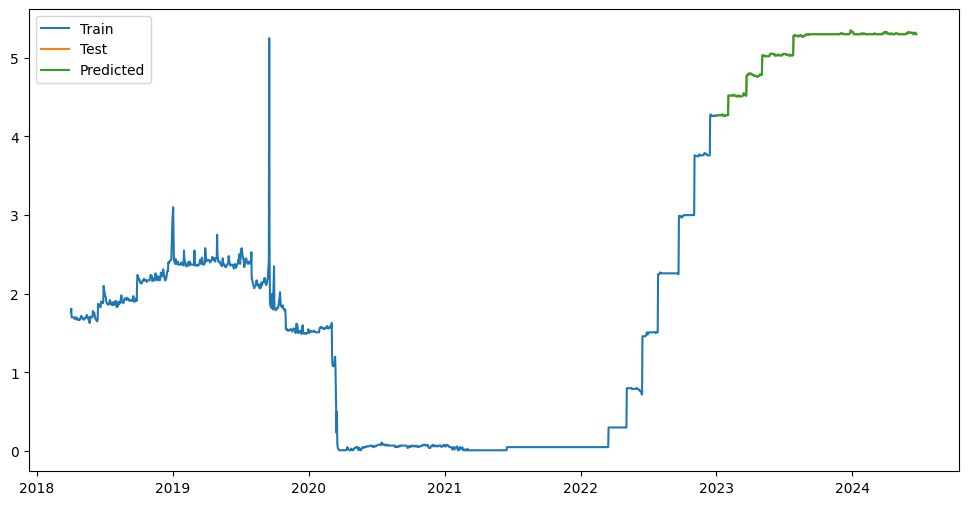

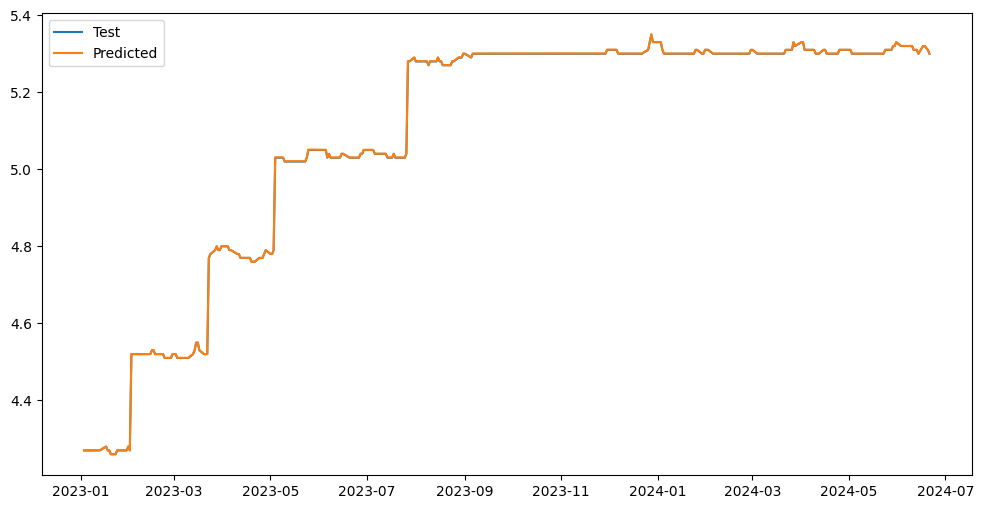

Mean Squared Error: 2.817774034874232e-07


In [165]:
# Prediction and plotting

# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Checking for leakage and accuracy

In [166]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

# Different

2018-04-02 00:00:00 2022-12-30 00:00:00
2023-01-03 00:00:00 2024-06-21 00:00:00


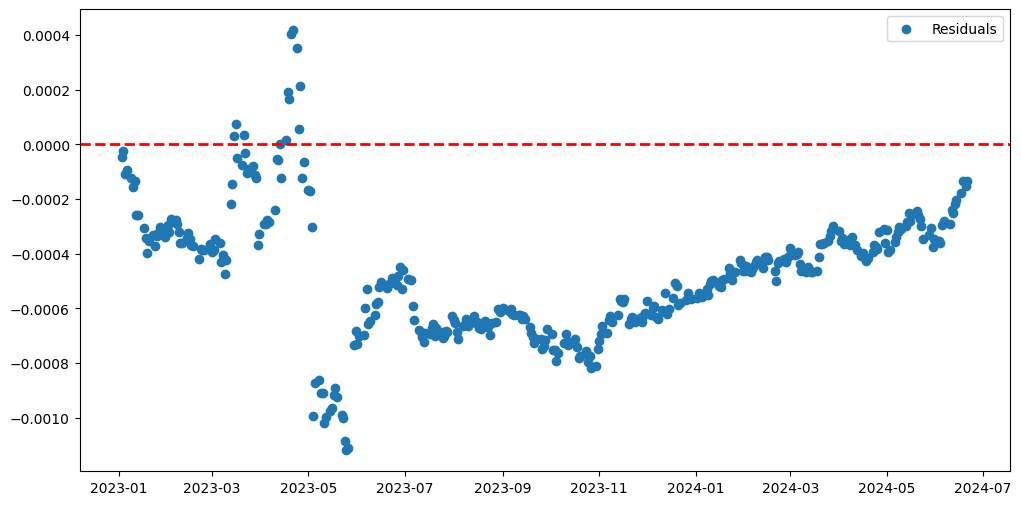

In [168]:
# Convert predictions to a pandas series with the correct index
# Convert predictions to a pandas series with the correct index
y_pred_df = pd.DataFrame(y_pred)
y_pred_df["Date"] = y_test.index
y_pred_df.set_index("Date", inplace=True)
y_pred_series = y_pred_df.squeeze()

# Calculate residuals
residuals = y_test - y_pred_series

# Plot residuals
plt.figure(figsize=(12, 6))
# plt.plot(residuals, label='Residuals') # line graph
plt.scatter(residuals.index, residuals, label='Residuals') # scatter plot
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.legend()
plt.show()

# very small residuals which is implies there is something off

# Final Dataframe Final without Fed Fund Rate

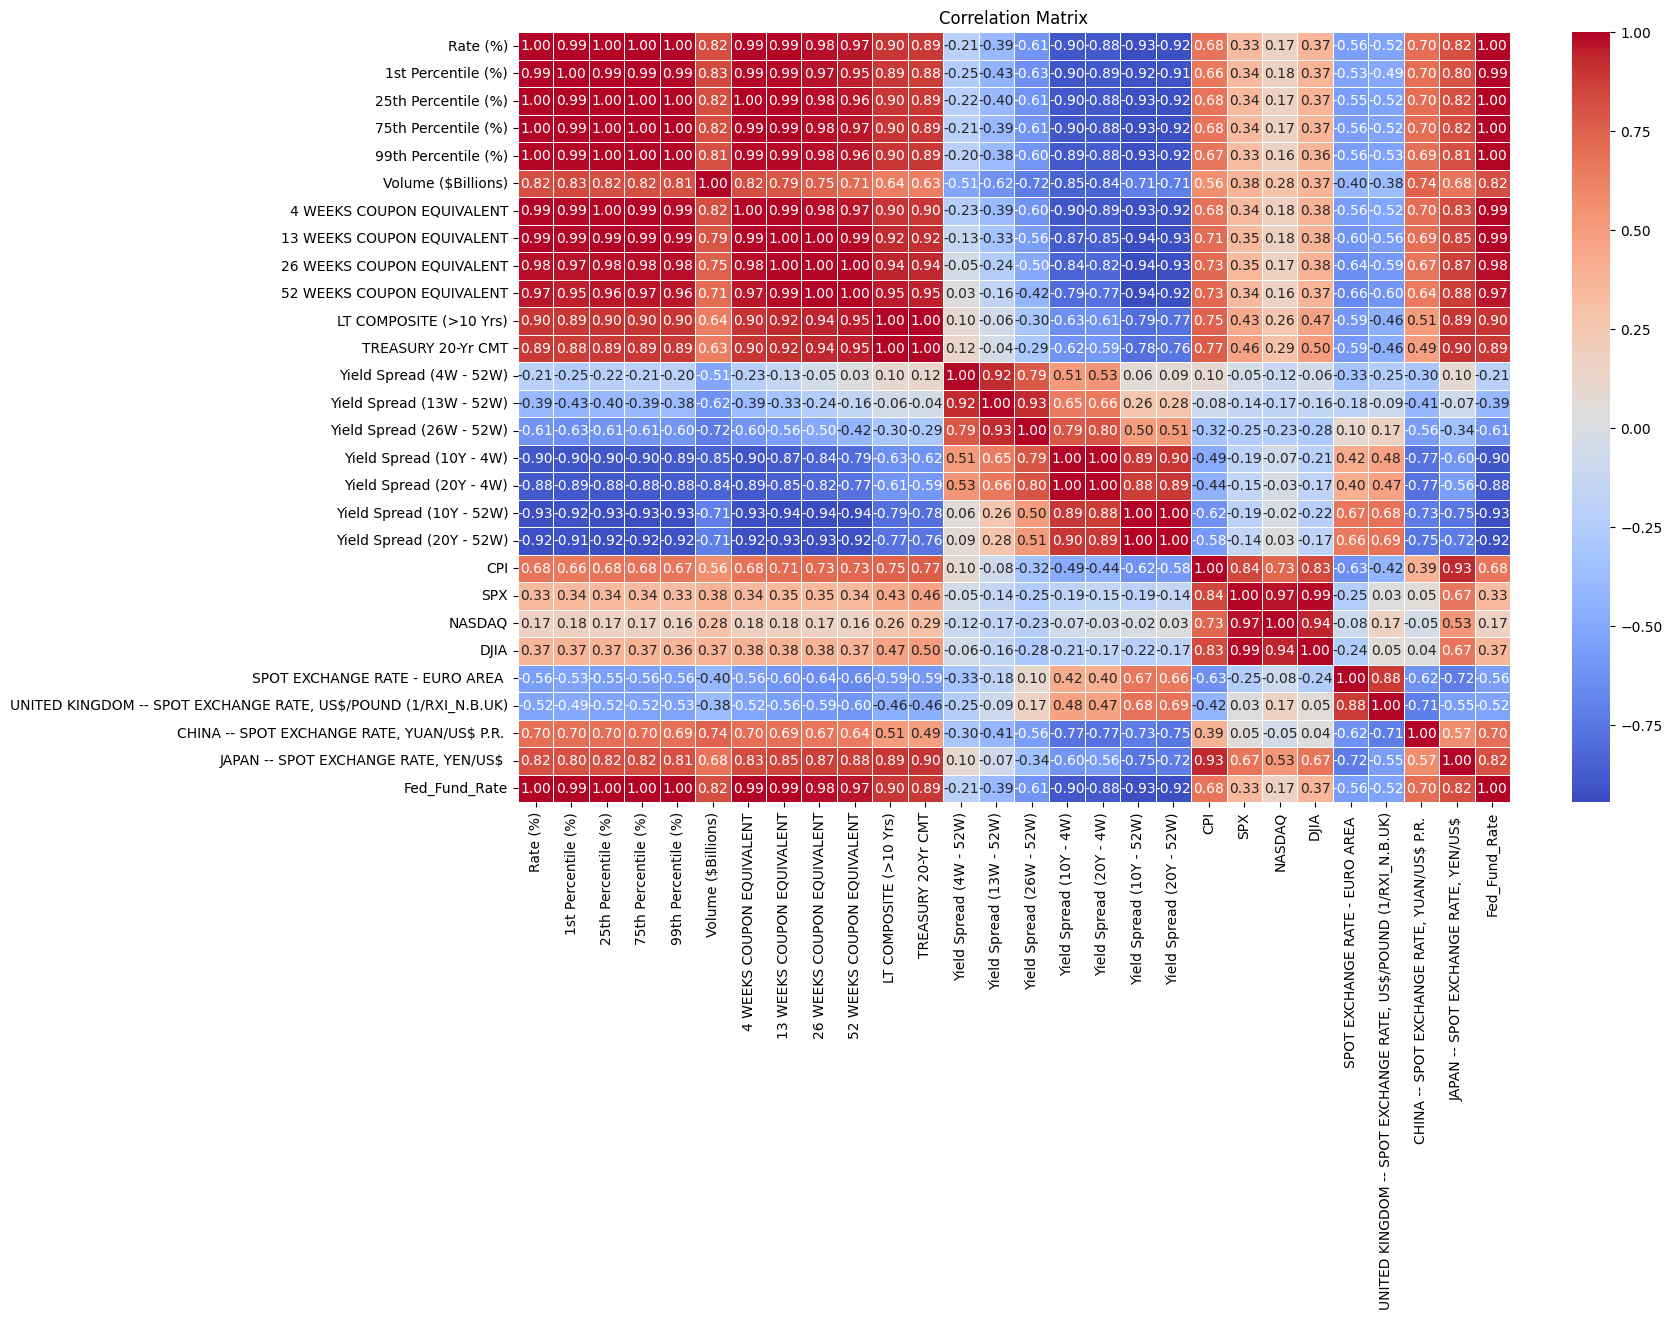

In [169]:
df_final = df_merged5.copy()

df_numeric = df_final.drop(columns=['Date', 'Rate Type'])
df_numeric.replace('ND', np.nan, inplace=True)

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Visualize the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [170]:
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)', 'Fed_Fund_Rate'])

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_final2.isna().sum())

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_final2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
4 WEEKS COUPON EQUIVALENT                                         0
13 WEEKS COUPON EQUIVALENT                                        0
26 WEEKS COUPON EQUIVALENT                                        0
52 WEEKS COUPON EQUIVALENT                                        0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                 

In [171]:
df_final2

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Yield Spread (10Y - 52W),Yield Spread (20Y - 52W),CPI,SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$"
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-02,1.77,361,1.67,1.77,1.92,2.08,2.90,2.85,0.41,0.31,...,0.82,0.77,250.546,2581.88,6870.12,23644.19,1.2288,1.4032,6.2785,105.9900
2018-04-03,1.81,344,1.70,1.75,1.92,2.09,2.96,2.90,0.39,0.34,...,0.87,0.81,250.546,2614.45,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500
2018-04-04,1.70,348,1.68,1.71,1.90,2.07,2.97,2.91,0.39,0.36,...,0.90,0.84,250.546,2644.69,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600
2018-04-05,1.70,349,1.66,1.72,1.92,2.07,3.01,2.95,0.41,0.35,...,0.94,0.88,250.546,2662.84,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800
2018-04-06,1.70,352,1.67,1.73,1.90,2.06,2.94,2.89,0.39,0.33,...,0.88,0.83,250.546,2604.47,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,5.30,785,5.35,5.39,5.35,5.06,4.42,4.46,-0.29,-0.33,...,-0.64,-0.60,314.069,5431.60,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800
2024-06-17,5.32,772,5.34,5.39,5.37,5.11,4.48,4.52,-0.23,-0.28,...,-0.63,-0.59,314.069,5473.23,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000
2024-06-18,5.32,763,5.29,5.38,5.36,5.09,4.43,4.47,-0.20,-0.29,...,-0.66,-0.62,314.069,5487.03,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100


In [172]:
# Split into train and test

train = df_final2[:'2022-12-31']
test = df_final2['2023-01-01':]

In [173]:
# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

In [174]:
# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [175]:
# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,1), seasonal_order= (0,0,0,0))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood            -2143294.249
Date:                Sun, 14 Jul 2024   AIC                        4286638.498
Time:                        16:07:42   BIC                        4286765.330
Sample:                             0   HQIC                       4286686.314
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1660   5.25e-05   3161.271      0.000       0.166       0.166
x2          3.446e+12   3.97e-05   8.67e+16      0.000    3.45e+12    3.45e+12
x3          6.011e+11   6.15e-05   9.78e+15      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


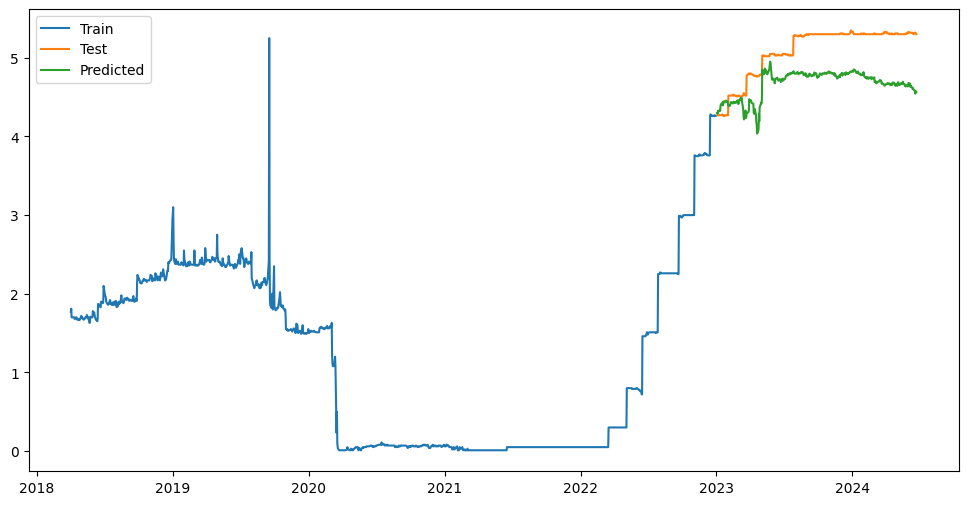

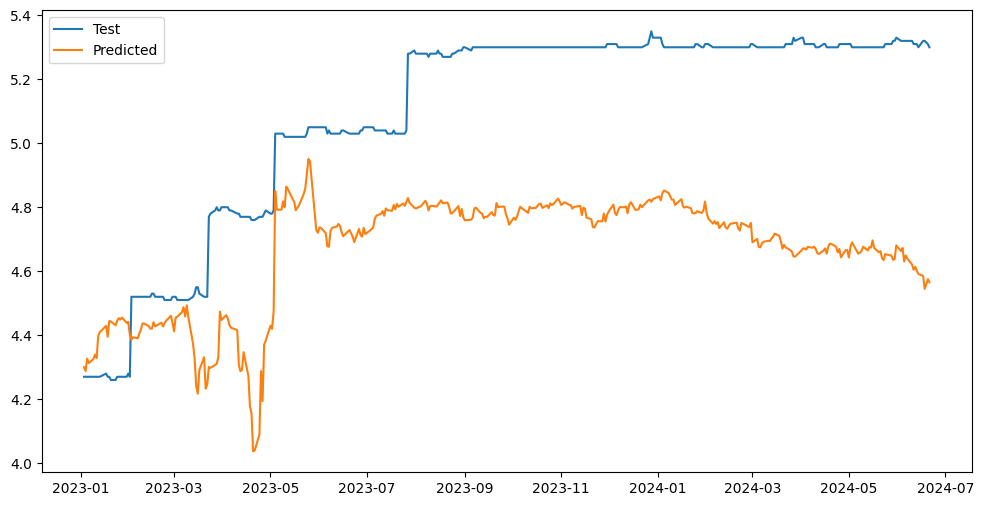

Mean Squared Error: 0.22610742585652513


In [176]:
# Prediction and plotting

# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Checking for leakage and accuracy

In [177]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

# Different

2018-04-02 00:00:00 2022-12-30 00:00:00
2023-01-03 00:00:00 2024-06-21 00:00:00


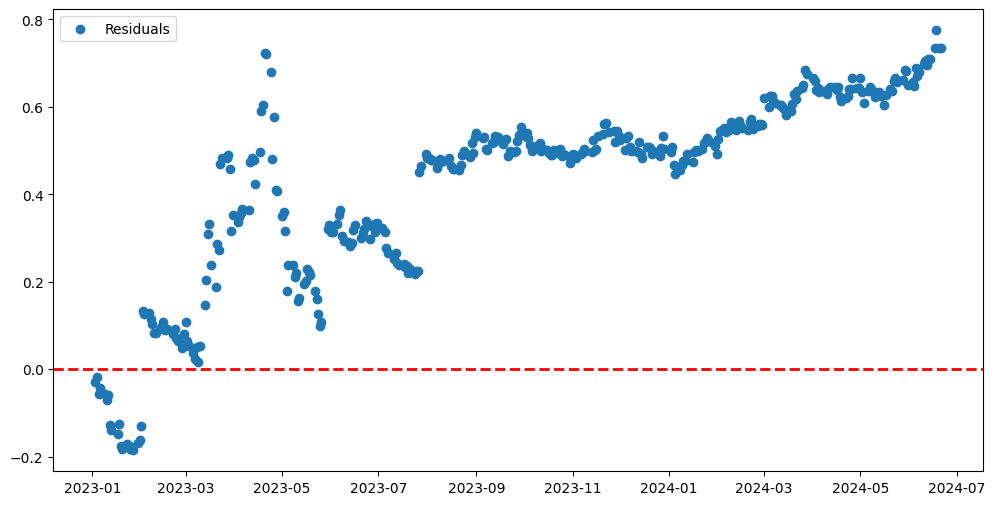

In [178]:
# Convert predictions to a pandas series with the correct index
y_pred_df = pd.DataFrame(y_pred)
y_pred_df["Date"] = y_test.index
y_pred_df.set_index("Date", inplace=True)
y_pred_series = y_pred_df.squeeze()

# Calculate residuals
residuals = y_test - y_pred_series

# Plot residuals
plt.figure(figsize=(12, 6))
# plt.plot(residuals, label='Residuals') # line graph
plt.scatter(residuals.index, residuals, label='Residuals') # scatter plot
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.legend()
plt.show()

# residual scale is bigger